In [57]:

import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import streamlit as st
import shap 
import random

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from numpy import asarray
from numpy import savetxt

from tensorflow.keras import layers, losses, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from aeon.transformations.collection.convolution_based import Rocket
from aeon.classification.convolution_based import Arsenal, RocketClassifier

# Datensatz unter: https://physionet.org/content/gaitpdb/1.0.0/

Die Daten werden über eine Sole des Herstellers "Infotronic" generiert"

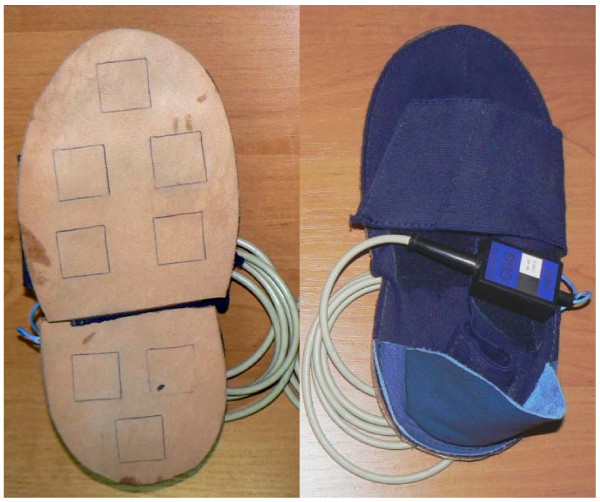

<h1>Integrate Data</h1>

In [58]:
#Initial data:
max_length = 400 # 

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


def load_and_sync_data(folder_path, label, event_col=0, event_threshold=0.5, max_length = 400): #1000
    """
    Lädt Daten, synchronisiert sie auf ein Event (z.B. Fußaufsatz) und trimmt sie auf gleiche Länge.
    
    Args:
        folder_path: Pfad zum Ordner mit den TSV-Dateien
        label: Label für die Daten (0 für Control, 1 für PD)
        event_col: Index der Spalte mit dem Event-Signal (z.B. Fersendruck)
        event_threshold: Schwellenwert für die Event-Erkennung
        max_length: Maximale Länge der Zeitreihen nach dem Trimmen
    Returns:
        X: np.array der Form (num_samples, num_features, max_length)
        y: np.array der Labels
    """
    all_data = []
    tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    
    for file_name in tsv_files:
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path, sep='\t', header=None)
        features = df.iloc[:, 1:19].values.T  # Shape: (18, num_timesteps)
        
        # 1. Synchronisation: Finde den ersten Event-Zeitpunkt
        event_idx = np.argmax(features[event_col] < event_threshold)
        
        # 2. Schneide die Daten ab diesem Zeitpunkt
        synced_features = features[:, event_idx:]
        
        # 3. Trimmen auf max_length (falls nötig)
        if synced_features.shape[1] > max_length:
            synced_features = synced_features[:, :max_length]
        all_data.append(synced_features)
    
    # 4. Finde die kürzeste Länge nach Synchronisation
    min_length = min([sample.shape[1] for sample in all_data])
    
    # 5. Trimme ALLE Daten auf diese Länge (für gleiche Dimensionen)
    X = np.array([sample[:, :min_length] for sample in all_data])
    y = np.repeat(label, len(all_data))
    
    return X, y

# --- Anwendung ---
# Lade und synchronisiere Control-Daten
X_CT, y_CT = load_and_sync_data(
    folder_path="./gait-in-parkinsons-disease-1.0.0/Control",
    label=1,
    event_col=0,  # Annahme: Spalte 0 enthält Fersendruck
    event_threshold=0.5)

# Lade und synchronisiere PD-Daten
X_PD, y_PD = load_and_sync_data(
    folder_path="./gait-in-parkinsons-disease-1.0.0/Pt",
    label=0,
    event_col=0,
    event_threshold=0.5)

# After combining your data as you did originally:
labels = np.concatenate((y_CT, y_PD), axis=0)
data = np.concatenate((X_CT, X_PD))
#visdata is for later extraction of dataframes for streamlit
visdata = data

# Then take first 4 sensors:
list16sensors = data[:, :16, :]  # numpy array version
list16sensors = data[:, :16, :]# nested list version

In [59]:
# first split for train and test data
train_val_data, test_data, train_val_labels, test_labels = train_test_split(X_CT, y_CT, test_size=0.1, random_state=21)

# Splitting the trainsplit again to carve validation data
train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.1, random_state=21)

# merging testplit together with Parkinsons-split to get a diverse testsplit
test_data = np.concatenate((test_data, np.array(X_PD)), axis=0)
test_labels =  np.concatenate((test_labels, np.array(y_PD)), axis=0)

# Print length of splits to analyse split-performance
print("train_data length: " + str(len(train_data)) + " | val_data length: " +  str(len(val_data)) + " | test_data length: " +  str(len(test_data)) + " (" + str(len(test_data) - len(X_PD)) + " control part)" )

anomalous_test_data = np.array(X_PD)

# Min/Max Normilizer auf allen Datensätzen
whole_datset = np.concatenate((X_PD, X_CT), axis= 0)
min_val = tf.reduce_min(whole_datset)
max_val = tf.reduce_max(whole_datset)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
val_data = (val_data - min_val) / (max_val - min_val)
anomalous_test_data = (anomalous_test_data - min_val) / (max_val - min_val)
data = (data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# Verändert die 0/1 Zuweisung der Probanden in eine False/True Zuweisung
train_labels = train_labels.astype(bool) 
test_labels = test_labels.astype(bool)
val_labels = val_labels.astype(bool)

print(train_data.shape)


train_data length: 69 | val_data length: 8 | test_data length: 202 (9 control part)
(69, 18, 400)


<h1>Explore the Data</h1>

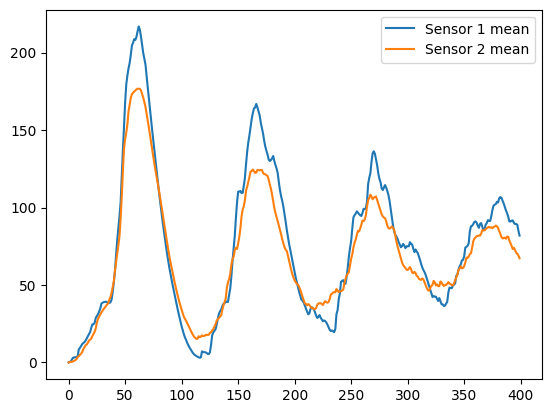

In [60]:
# Berechnen Sie den Durchschnitt über alle Sensoren für jeden Zeitpunkt
mean_CT = np.mean(X_CT, axis=0)  # Axis=0 bedeutet über Sensoren mitteln
mean_PD = np.mean(X_PD, axis=0)

plt.plot(mean_CT[0], label="Sensor 1 mean")
plt.plot(mean_PD[0], label="Sensor 2 mean")
plt.legend()


C:\Users\PE-GM\AppData\Local\Temp\ipykernel_15628\4276661045.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


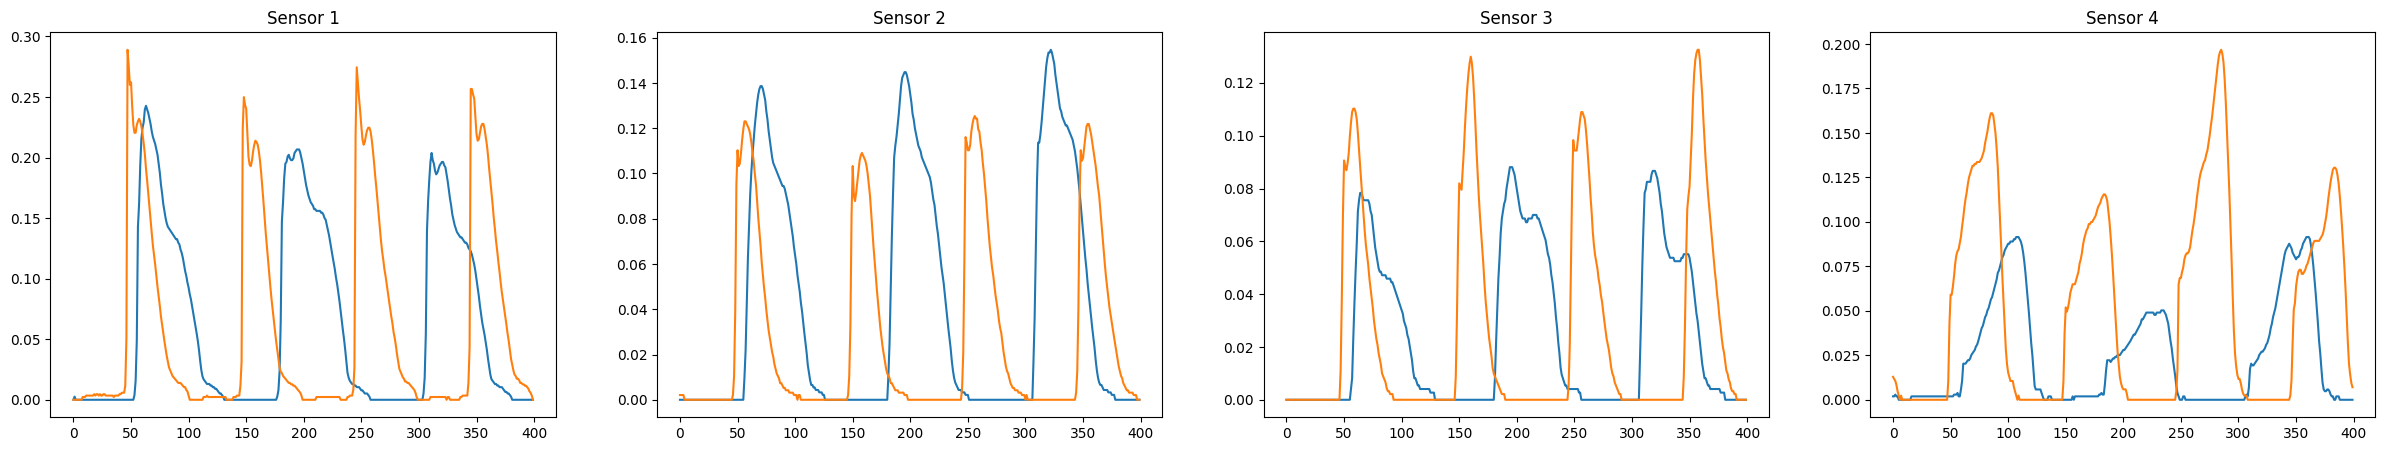

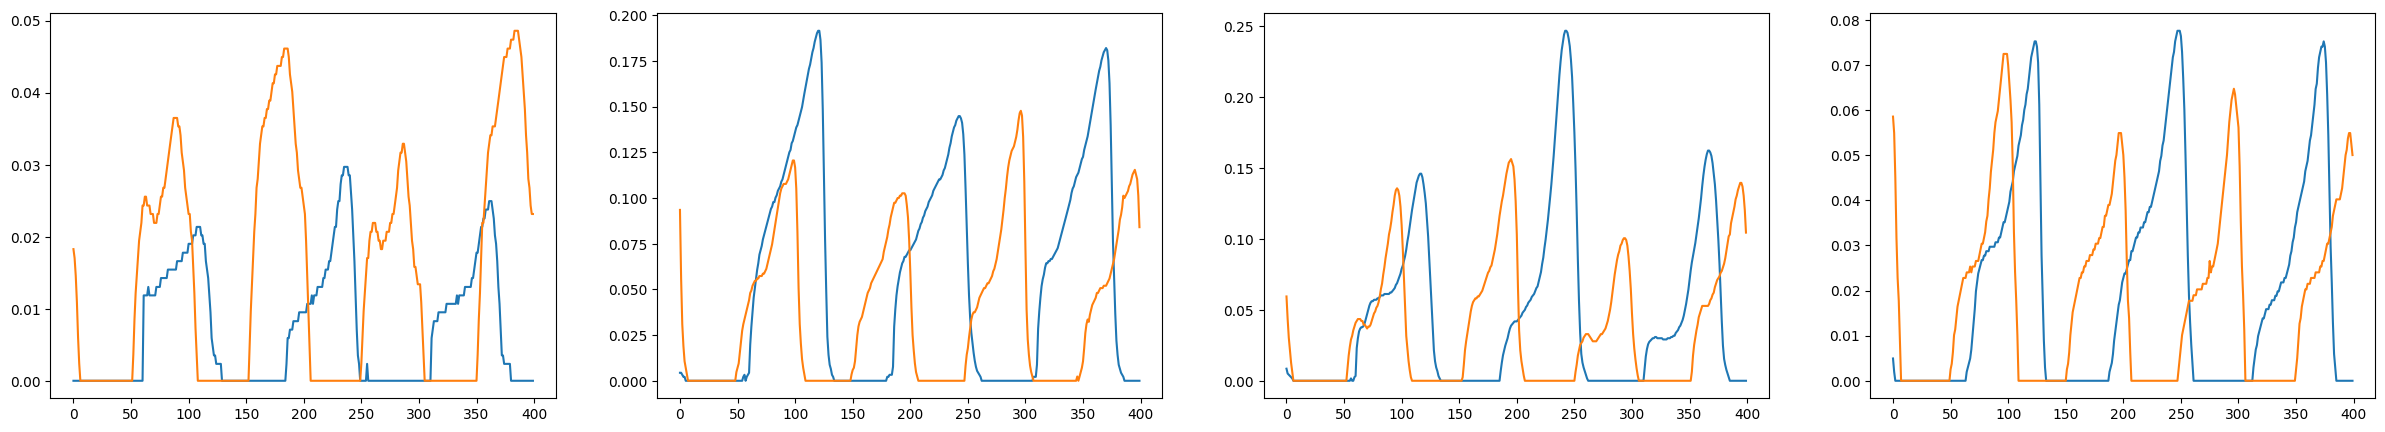

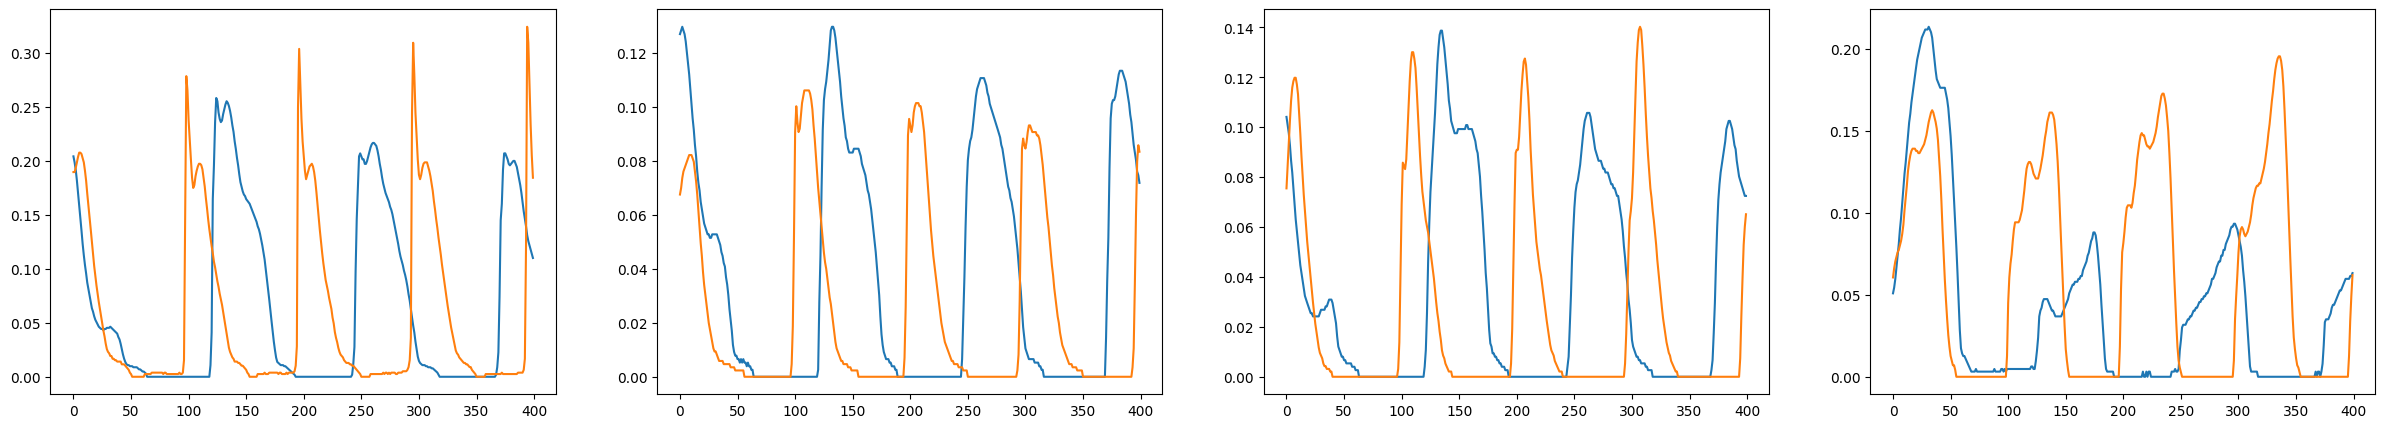

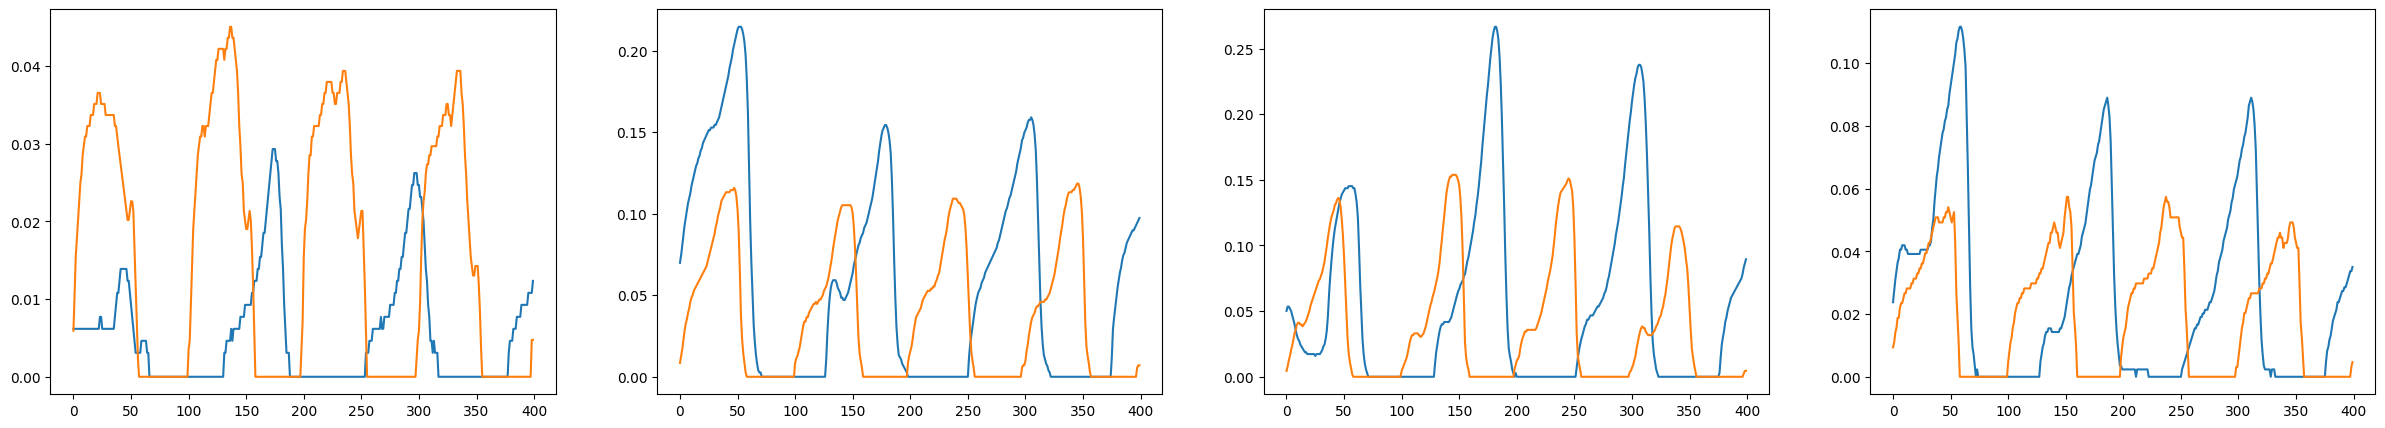

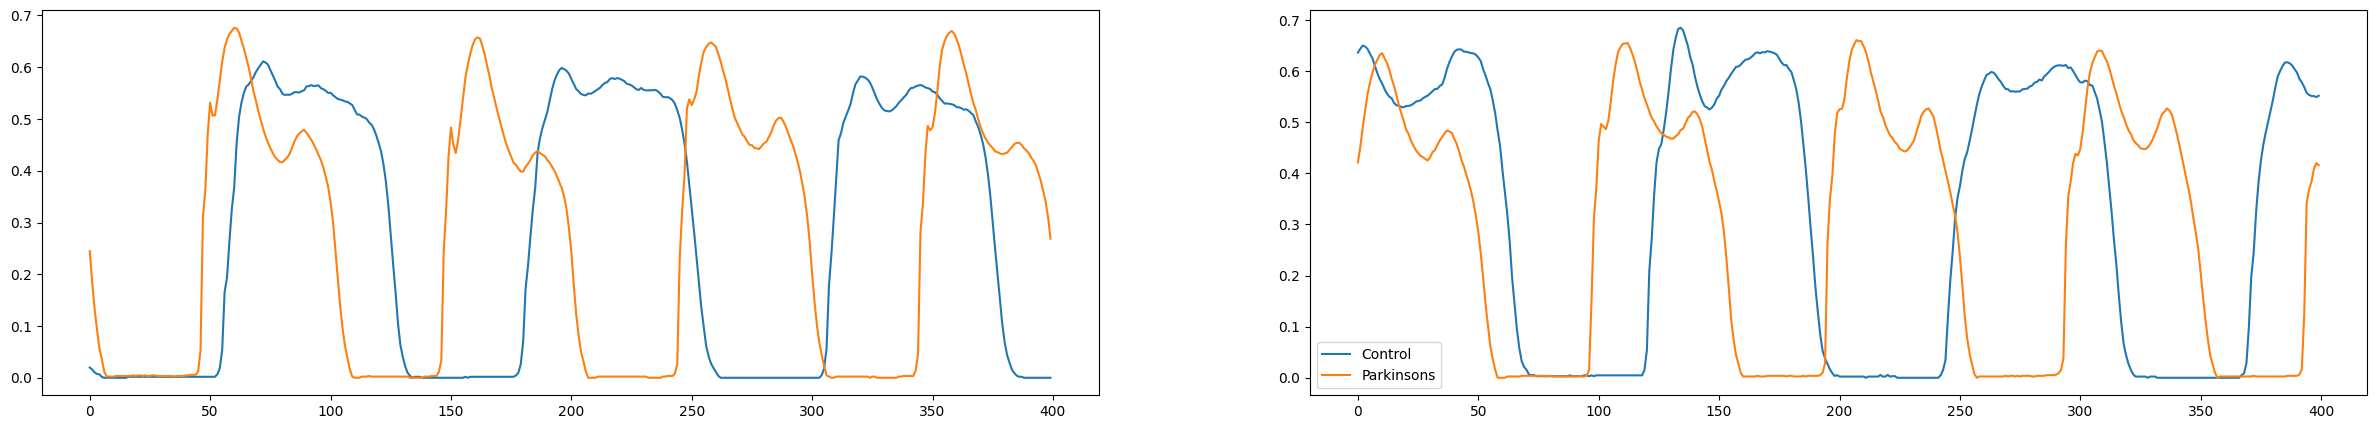

In [61]:
# Visuelle Darstellung der Parameter zweier Probanden
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(30,5))

ax1.set_title('Sensor 1')
ax2.set_title('Sensor 2')
ax3.set_title('Sensor 3')
ax4.set_title('Sensor 4')

ax1.plot(data[0][0])
ax1.plot(data[200][0])

ax2.plot(data[0][1])
ax2.plot(data[200][1])

ax3.plot(data[0][2])
ax3.plot(data[200][2])

ax4.plot(data[0][3])
ax4.plot(data[200][3])

fig, (ax5, ax6, ax7, ax8) = plt.subplots(nrows=1, ncols=4, figsize=(30,5))

ax5.plot(data[0][4])
ax5.plot(data[200][4])

ax6.plot(data[0][5])
ax6.plot(data[200][5])

ax7.plot(data[0][6])
ax7.plot(data[200][6])

ax8.plot(data[0][7])
ax8.plot(data[200][7])

fig, (ax9, ax10, ax11, ax12) = plt.subplots(nrows=1, ncols=4, figsize=(30,5))

ax9.plot(data[0][8])
ax9.plot(data[200][8])

ax10.plot(data[0][9])
ax10.plot(data[200][9])

ax11.plot(data[0][10])
ax11.plot(data[200][10])

ax12.plot(data[0][11])
ax12.plot(data[200][11])

fig, (ax13, ax14, ax15, ax16) = plt.subplots(nrows=1, ncols=4, figsize=(30,5))

ax13.plot(data[0][12])
ax13.plot(data[200][12])

ax14.plot(data[0][13])
ax14.plot(data[200][13])

ax15.plot(data[0][14])
ax15.plot(data[200][14])

ax16.plot(data[0][15])
ax16.plot(data[200][15])

fig, (ax17, ax18) = plt.subplots(nrows=1, ncols=2, figsize=(30,5))

ax17.plot(data[0][16])
ax17.plot(data[200][16])

ax18.plot(data[0][17])
ax18.plot(data[200][17])



plt.legend(labels=["Control", "Parkinsons"])
fig.show()

In [62]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(), # Flatten Layer, da wir 3 Dimensionale Daten haben (Person,Sensor,Zeitpunkt)
      # layers.Dense(1048, activation="relu"),
      # layers.Dense(512, activation="relu"),
      #layers.Dense(256, activation="relu"),
      #layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu"),      
      layers.Dense(4, activation="relu"),
      ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(4, activation="relu"),
      #layers.Dense(8, activation="relu"),
      layers.Dense(16, activation="relu"),
      #layers.Dense(32, activation="relu"),
      #layers.Dense(64, activation="relu"),
      #layers.Dense(128, activation="relu"),
      #layers.Dense(256, activation="relu"),
      #layers.Dense(512, activation="relu"),
      #layers.Dense(1024, activation="relu"),
      layers.Dense(max_length * 18, activation="sigmoid"),  # Must match 4034 * 18
      layers.Reshape((18, max_length))
      ],)
    

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')



In [63]:
history = autoencoder.fit(train_data, train_data,
          epochs=200,
          #20
          batch_size=1,
          #512
          # validation_split = nummerischen Wert angeben (nur n Teil, was wir zum validieren nutzt),
          validation_data=(val_data, val_data),
          shuffle="True") # Vielleicht auch n wenig probieren

Epoch 1/200
69/69 [==============================] - 2s 8ms/step - loss: 0.2621 - val_loss: 0.0531
Epoch 2/200
69/69 [==============================] - 0s 4ms/step - loss: 0.0451 - val_loss: 0.0531
Epoch 3/200
69/69 [==============================] - 0s 5ms/step - loss: 0.0440 - val_loss: 0.0529
Epoch 4/200
69/69 [==============================] - 0s 5ms/step - loss: 0.0432 - val_loss: 0.0531
Epoch 5/200
69/69 [==============================] - 0s 4ms/step - loss: 0.0423 - val_loss: 0.0524
Epoch 6/200
69/69 [==============================] - 0s 5ms/step - loss: 0.0418 - val_loss: 0.0528
Epoch 7/200
69/69 [==============================] - 0s 5ms/step - loss: 0.0411 - val_loss: 0.0532
Epoch 8/200
69/69 [==============================] - 0s 4ms/step - loss: 0.0403 - val_loss: 0.0545
Epoch 9/200
69/69 [==============================] - 0s 4ms/step - loss: 0.0404 - val_loss: 0.0522
Epoch 10/200
69/69 [==============================] - 0s 4ms/step - loss: 0.0396 - val_loss: 0.0517
Epoch 11/

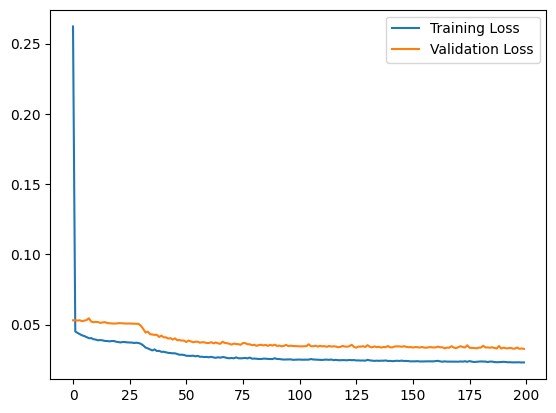

In [64]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [65]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

# plt.hist(train_loss[None,:], bins=50)
# plt.xlabel("Train loss")
# plt.ylabel("No of examples")
# plt.show()

threshold = np.mean(train_loss) + 1.5 * np.std(train_loss)
print("Threshold: ", threshold)


3/3 [==============================] - 0s 2ms/step
Threshold:  0.05843639839440584


In [66]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [67]:

# Step 1: Predict the test data
reconstructed_test_data = autoencoder.predict(test_data)

# Step 2: Calculate reconstruction error
reconstruction_error = np.mean(np.abs(reconstructed_test_data - test_data), axis=(1, 2))

# Step 3: Set a threshold for anomaly detection
# You might need to adjust this threshold based on a validation set or domain knowledge
# threshold = np.percentile(reconstruction_error, 95)  # Example: 95th percentile

# Classify as anomalous if error is greater than threshold
predicted_anomalies = reconstruction_error > threshold

# Step 4: Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_anomalies)
print(f"Model accuracy: {accuracy:.2f}")


7/7 [==============================] - 0s 1ms/step
Model accuracy: 0.92


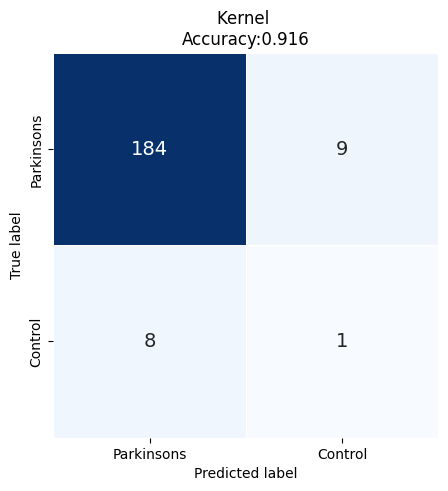

In [68]:
# Creates a confusion matrix
cm = confusion_matrix(test_labels, predicted_anomalies) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index   = ['Parkinsons', 'Control'], 
                     columns = ['Parkinsons', 'Control'])

plt.figure(figsize=(5,5))
sns.heatmap(cm_df, annot=True, fmt="d", linewidths=0.5, cmap='Blues', cbar=False, annot_kws={'size':14}, square=True)
plt.title('Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(test_labels, predicted_anomalies)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [69]:
# Finding useful examples for Dashboard (4 people)
# Find indices of correctly and incorrectly classified samples
correct_indices = np.where(predicted_anomalies == test_labels)[0]
incorrect_indices = np.where(predicted_anomalies != test_labels)[0]
    
print(" Correct indices ")
print(correct_indices)
print("\n Incorect indices")
print(incorrect_indices)
print("True labels")
print(test_labels[incorrect_indices])
print("Predicted labels")
print(predicted_anomalies[incorrect_indices])
print(reconstruction_error[incorrect_indices])

 Correct indices 
[  2   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  88  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 117 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 181 182 183 184 185 186 187 188 189 191 192 193 194 195 196
 197 198 199 200 201]

 Incorect indices
[  0   1   3   4   5   6   7   8  87  89 113 114 115 116 118 180 190]
True labels
[ True  True  True  True  True  True  True  True False False False False
 False False False False False]
Predicted labels
[False 

Text(0.5, 1.0, 'Parkinsons patient that was incorrectly identified as Control')

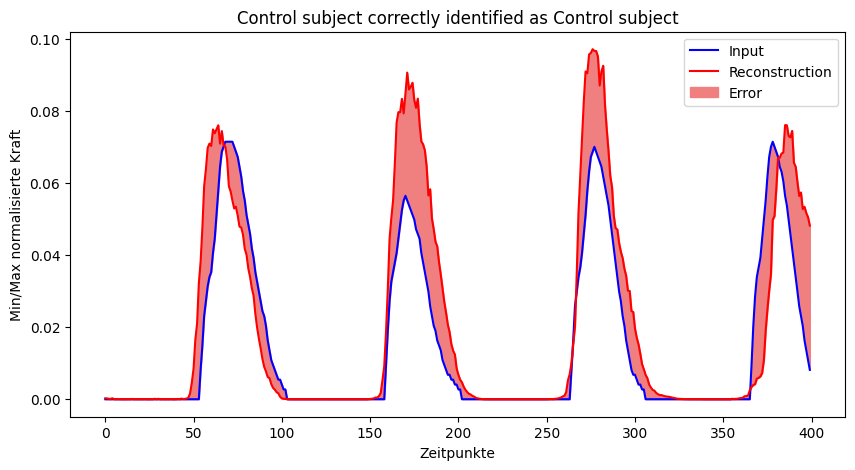

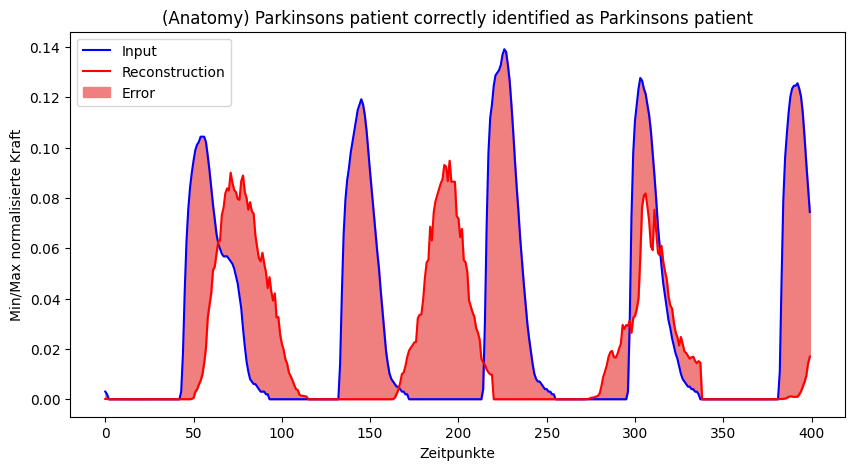

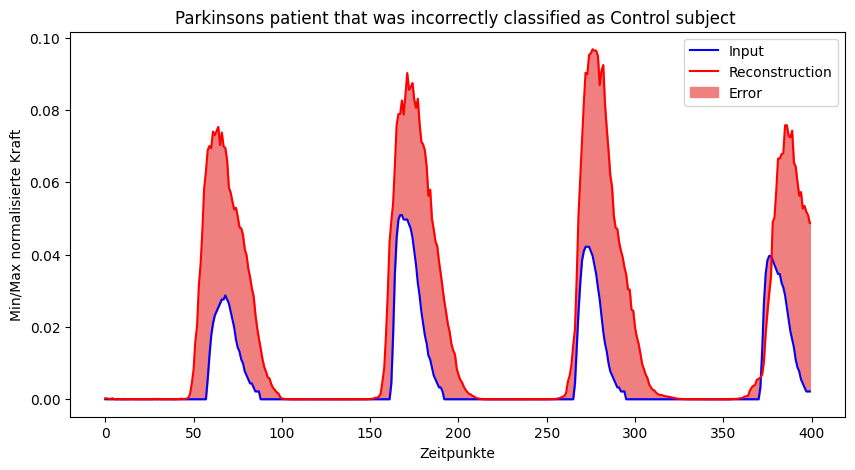

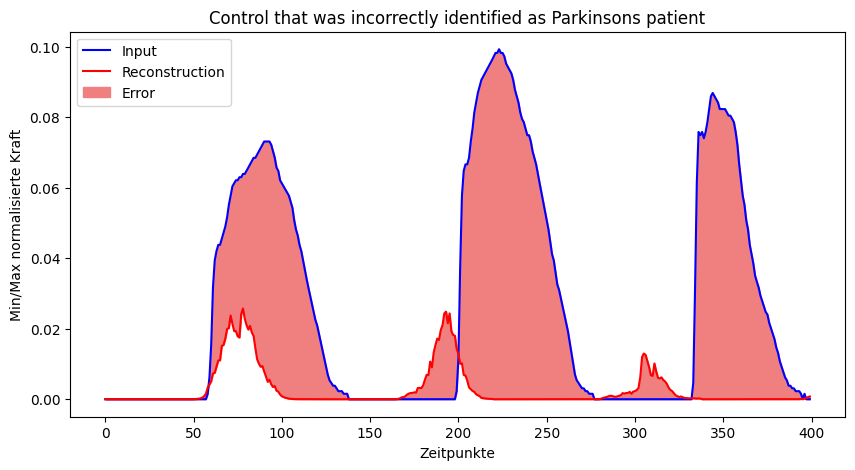

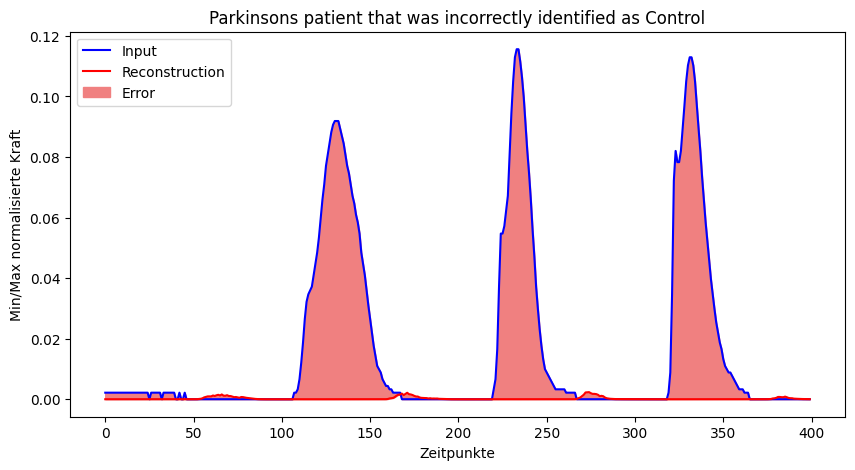

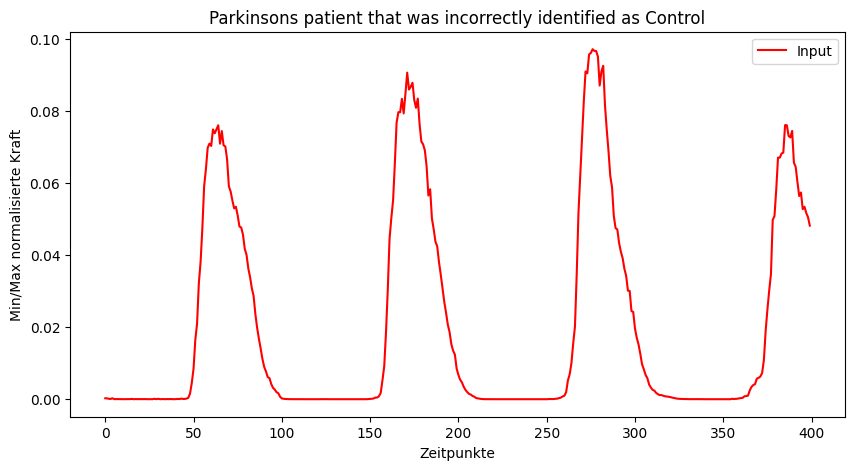

In [70]:
# Reconstruction eines Probands anhand des ersten Sensors (Vorderer Teil vom Fuß, Richtung Zehe)

encoded_data = autoencoder.encoder(test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

CTCT = 2
PTPT = 17
CTPT = 5
PTCT = 190

plt.subplots(nrows=1, ncols=1, figsize=(10,5))
plt.plot(test_data[PTPT][2], 'b')
plt.plot(decoded_data[PTPT][2], 'r')
plt.fill_between(np.arange(max_length), decoded_data[PTPT][2], test_data[PTPT][2], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.ylabel('Min/Max normalisierte Kraft')
plt.xlabel('Zeitpunkte')
plt.title("Control subject correctly identified as Control subject")

plt.subplots(nrows=1, ncols=1, figsize=(10,5))
plt.plot(test_data[CTCT][2], 'b')
plt.plot(decoded_data[CTCT][2], 'r')
plt.fill_between(np.arange(max_length), decoded_data[CTCT][2], test_data[CTCT][2], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.ylabel('Min/Max normalisierte Kraft')
plt.xlabel('Zeitpunkte')
plt.title("(Anatomy) Parkinsons patient correctly identified as Parkinsons patient")



plt.subplots(nrows=1, ncols=1, figsize=(10,5))
plt.plot(test_data[CTPT][2], 'b')
plt.plot(decoded_data[CTPT][2], 'r')
plt.fill_between(np.arange(max_length), decoded_data[CTPT][2], test_data[CTPT][2], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.ylabel('Min/Max normalisierte Kraft')
plt.xlabel('Zeitpunkte')
plt.title("Parkinsons patient that was incorrectly classified as Control subject ")

plt.subplots(nrows=1, ncols=1, figsize=(10,5))
plt.plot(test_data[PTCT][2], 'b')
plt.plot(decoded_data[PTCT][2], 'r')
plt.fill_between(np.arange(max_length), decoded_data[PTCT][2], test_data[PTCT][2], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.ylabel('Min/Max normalisierte Kraft')
plt.xlabel('Zeitpunkte')
plt.title("Control that was incorrectly identified as Parkinsons patient")

# explainer when 
plt.subplots(nrows=1, ncols=1, figsize=(10,5))
plt.plot(test_data[118][2], 'b')
plt.plot(decoded_data[118][2], 'r')
plt.fill_between(np.arange(max_length), decoded_data[118][2], test_data[118][2], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.ylabel('Min/Max normalisierte Kraft')
plt.xlabel('Zeitpunkte')
plt.title("Parkinsons patient that was incorrectly identified as Control")

# Priting both plots seperate for explaining model!
plt.subplots(nrows=1, ncols=1, figsize=(10,5))
#plt.plot(test_data[PTPT][2], 'b')
plt.plot(decoded_data[PTPT][2], 'r')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.ylabel('Min/Max normalisierte Kraft')
plt.xlabel('Zeitpunkte')
plt.title("Parkinsons patient that was incorrectly identified as Control")


<h1> CNN Network </h1>

# first split for train and test data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

# Splitting the trainsplit again to carve validation data
# train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.2, random_state=21)

# merging testplit together with Parkinsons-split to get a diverse testsplit
test_data = np.concatenate((test_data, np.array(X_PD)), axis=0)
test_labels =  np.concatenate((test_labels, np.array(y_PD)), axis=0)


# Min/Max Normilizer auf allen Datensätzen
whole_datset = np.concatenate((X_PD, X_CT), axis= 0)
min_val = tf.reduce_min(whole_datset)
max_val = tf.reduce_max(whole_datset)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
# val_data = (val_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
#val_data = tf.cast(val_data, tf.float32)

# Verändert die 0/1 Zuweisung der Probanden in eine False/True Zuweisung
train_labels = train_labels.astype(bool) 
test_labels = test_labels.astype(bool)
# val_labels = val_labels.astype(bool)

# from sktime.classification.kernel_based import RocketClassifier
# from sktime.datasets import load_unit_test

X_train, y_train = np.asarray(train_data, dtype= np.float32), np.asarray(train_labels, dtype= np.float32)
X_test, y_test = np.asarray(test_data, dtype= np.float32), np.asarray(test_labels, dtype= np.float32)
#X_val, y_val = np.asarray(val_data, dtype= np.float32), np.asarray(val_labels, dtype= np.float32)
trf = RocketClassifier(n_kernels= 20000, random_state = 42)

#trf = Rocket(n_kernels=30, n_jobs =-1, random_state = 42)
trf.fit(X_train, y_train)
# Get predictions from the CNN model

In [71]:
"""
data = np.asarray(data, dtype= np.float32)

#CNN
versuch1 = trf.predict(data)
versuch1 = [ int(x) for x in versuch1]

print(versuch1)
#Autoencoder

# Step 1: Predict the test data
reconstructed_test_data = autoencoder.predict(data)
# Step 2: Calculate reconstruction error
reconstruction_error = np.mean(np.abs(reconstructed_test_data - data), axis=(1, 2))
# Classify as anomalous if error is greater than threshold
predicted_anomalies = reconstruction_error > threshold
predicted_anomalies = 1*predicted_anomalies

print(versuch1)
print(predicted_anomalies)
#True labels
print(labels)"""

"""print("CNN")
print(versuch1)
print("Autoencoder")
print(predicted_anomalies)
#True labels
print("True labels")
print(labels)
matching_indices = np.where(predicted_anomalies == versuch1)[0]
#print(matching_indices)
unmatching_indices = np.where(predicted_anomalies != versuch1)[0]
print("Unmatching labels")
print(unmatching_indices)
#print(labels[unmatching_indices])
index = 164
print("CNN " + str(versuch1[index]) +" AE "+ str(predicted_anomalies[index]) +" true labels "+ str(labels[index]))"""

"""# Find indices of correctly and incorrectly classified samples
correct_indices = np.where(y_pred == y_test)[0]
incorrect_indices = np.where(y_pred != y_test)[0]

print(" Correct indices ")
print(correct_indices)
print("\n Incorect indices")
print(incorrect_indices)
print("True labels")
print(y_test[incorrect_indices])
print("Predicted labels")
print(y_pred[incorrect_indices])

# Finding useful examples for Dashboard (4 people)
# Find indices of correctly and incorrectly classified samples
correct_indices = np.where(predicted_anomalies == test_labels)[0]
incorrect_indices = np.where(predicted_anomalies != test_labels)[0]
    
print(" Correct indices ")
print(correct_indices)
print("\n Incorect indices")
print(incorrect_indices)
print("True labels")
print(test_labels[incorrect_indices])
print("Predicted labels")
print(predicted_anomalies[incorrect_indices])
print(reconstruction_error[incorrect_indices])"""

'# Find indices of correctly and incorrectly classified samples\ncorrect_indices = np.where(y_pred == y_test)[0]\nincorrect_indices = np.where(y_pred != y_test)[0]\n\nprint(" Correct indices ")\nprint(correct_indices)\nprint("\n Incorect indices")\nprint(incorrect_indices)\nprint("True labels")\nprint(y_test[incorrect_indices])\nprint("Predicted labels")\nprint(y_pred[incorrect_indices])\n\n# Finding useful examples for Dashboard (4 people)\n# Find indices of correctly and incorrectly classified samples\ncorrect_indices = np.where(predicted_anomalies == test_labels)[0]\nincorrect_indices = np.where(predicted_anomalies != test_labels)[0]\n    \nprint(" Correct indices ")\nprint(correct_indices)\nprint("\n Incorect indices")\nprint(incorrect_indices)\nprint("True labels")\nprint(test_labels[incorrect_indices])\nprint("Predicted labels")\nprint(predicted_anomalies[incorrect_indices])\nprint(reconstruction_error[incorrect_indices])'

<h1> Streamlit conversions </h1>

In [72]:
# Proband 53, 170, 40 und 164

"""Visualisierung der Probanden, die im Dashbaord angezeigt werden sollen
Identifikationen wurden seperat ermittelt, indem man beide Modelle auf dem vollen Datensatz testet und dementsprechend die orginale indexe bekommt. Wurde seperat gemacht.
CNN 1 AE 1 True 1 : ID 53
CNN 0 AE 0 True 0 : ID 170
CNN 0 AE 0 True 1 : ID 40
CNN 0 AE 1 True 0 : ID 164

#Visalisierung der Prbanden
# Indizes der ausgewählten Proben
sample_indices = [53, 170, 40, 164]
num_samples = len(sample_indices)
num_features = data.shape[1]  # Anzahl der Sensoren

# Erstelle eine Figure mit Subplots
fig, axes = plt.subplots(num_samples, 1, figsize=(12, 3 * num_samples), sharex=True)

# Plot für jede Probe
for i, idx in enumerate(sample_indices):
    sample_data = data[idx]  # Shape: (num_features, max_length)
    
    # Plot aller Sensoren für diese Probe
    for feature in range(num_features):
        axes[i].plot(sample_data[feature], label=f'Sensor {feature+1}')
    
    axes[i].set_title(f'Zeitreihe für Probe {idx}')
    axes[i].set_ylabel('Wert')
    axes[i].grid(True)

# Gemeinsame X-Achse beschriften
axes[-1].set_xlabel('Zeitschritte')

# Legende außerhalb des Plots setzen (optional, kann bei vielen Sensoren unübersichtlich sein)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
"""

"Visualisierung der Probanden, die im Dashbaord angezeigt werden sollen\nIdentifikationen wurden seperat ermittelt, indem man beide Modelle auf dem vollen Datensatz testet und dementsprechend die orginale indexe bekommt. Wurde seperat gemacht.\nCNN 1 AE 1 True 1 : ID 53\nCNN 0 AE 0 True 0 : ID 170\nCNN 0 AE 0 True 1 : ID 40\nCNN 0 AE 1 True 0 : ID 164\n\n#Visalisierung der Prbanden\n# Indizes der ausgewählten Proben\nsample_indices = [53, 170, 40, 164]\nnum_samples = len(sample_indices)\nnum_features = data.shape[1]  # Anzahl der Sensoren\n\n# Erstelle eine Figure mit Subplots\nfig, axes = plt.subplots(num_samples, 1, figsize=(12, 3 * num_samples), sharex=True)\n\n# Plot für jede Probe\nfor i, idx in enumerate(sample_indices):\n    sample_data = data[idx]  # Shape: (num_features, max_length)\n    \n    # Plot aller Sensoren für diese Probe\n    for feature in range(num_features):\n        axes[i].plot(sample_data[feature], label=f'Sensor {feature+1}')\n    \n    axes[i].set_title(f'Zei

In [73]:
# Visualisierung der Probanden, die im Dashboard angezeigt werden sollen
#CNN 1 AE 1 True 1 : ID 53

CNNCT_AECT_TCT = pd.DataFrame(visdata[53]).T # index=[Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor9,Sensor10,Sensor11,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16]
CNNCT_AECT_TCT = CNNCT_AECT_TCT.rename_axis('Sensors', axis=1)
CNNCT_AECT_TCT = CNNCT_AECT_TCT.rename_axis('Timestamps', axis=0)
#CNNCT_AECT_TCT.to_datetime(1490195805433502912, unit='ns')
CNNCT_AECT_TCT.to_csv("CNNCT_AECT_TCT.csv")

#CNN 0 AE 0 True 0 : ID 170
CNNPT_AEPT_TPT = pd.DataFrame(visdata[170]).T
CNNPT_AEPT_TPT = CNNPT_AEPT_TPT.rename_axis('Sensors', axis=1)
CNNPT_AEPT_TPT = CNNPT_AEPT_TPT.rename_axis('Timestamps', axis=0)
CNNPT_AEPT_TPT.to_csv("CNNPT_AEPT_TPT.csv")

#CNN 0 AE 0 True 1 : ID 40
CNNPT_AEPT_TCT = pd.DataFrame(visdata[40]).T
CNNPT_AEPT_TCT = CNNPT_AEPT_TCT.rename_axis('Sensors', axis=1)
CNNPT_AEPT_TCT = CNNPT_AEPT_TCT.rename_axis('Timestamps', axis=0)
CNNPT_AEPT_TCT.to_csv("CNNPT_AEPT_TCT.csv")

#CNN 0 AE 1 True 0 : ID 164
CNNPT_AECT_TPT = pd.DataFrame(visdata[164]).T
CNNPT_AECT_TPT = CNNPT_AECT_TPT.rename_axis('Sensors', axis=1)
CNNPT_AECT_TPT = CNNPT_AECT_TPT.rename_axis('Timestamps', axis=0)
CNNPT_AECT_TPT.to_csv("CNNPT_AECT_TPT.csv")


Text(0.5, 1.0, 'Control that was incorrectly identified as Parkinsons patient')

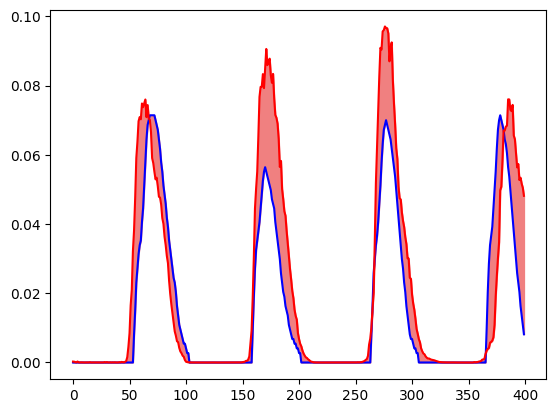

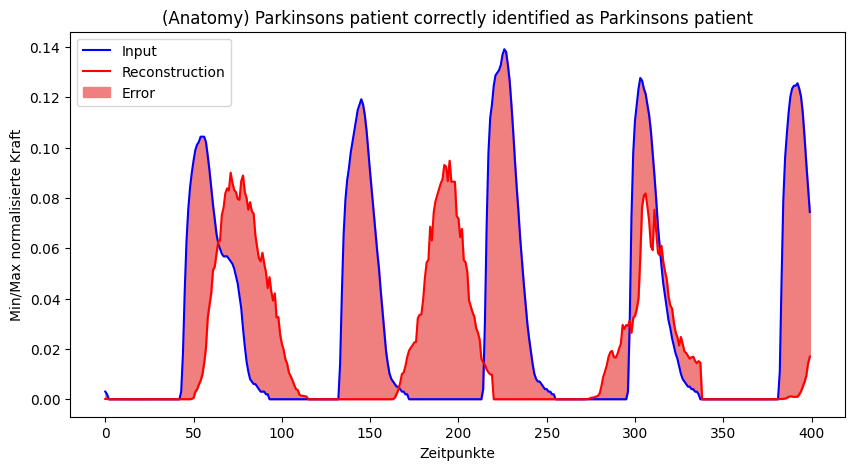

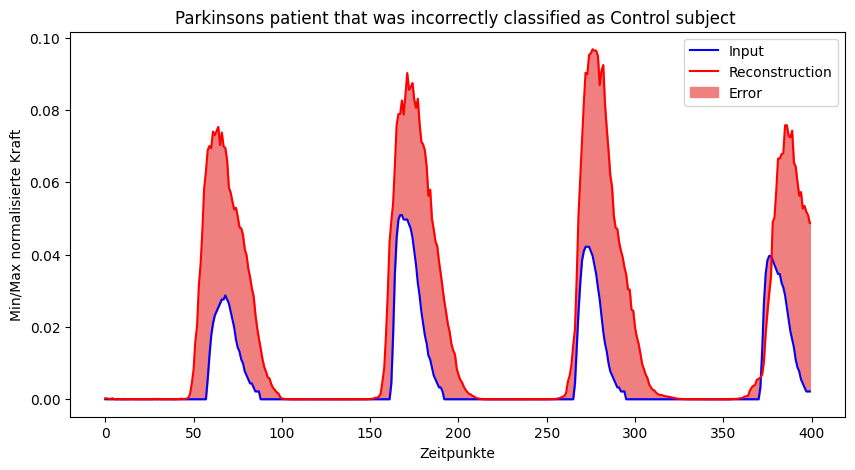

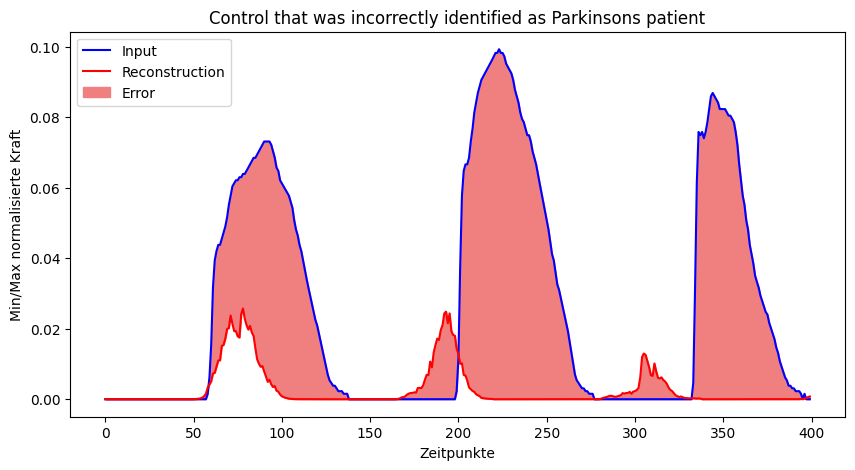

In [ ]:
#Reconstruction exportation for streamlit
# Correctly classified as Control
AECTTCT = {
    'True Data': [test_data[PTPT][2]],
    'Decoded_Data': [decoded_data[PTPT][2]]
}
df = pd.DataFrame(AECTTCT)
AECTTCT.to_csv("AECTTCT.csv")


AEPTCPT = {
    'True Data': [test_data[CTCT][2]],
    'Decoded_Data': [decoded_data[CTCT][2]]
}
df = pd.DataFrame(AEPTCPT)
AEPTCPT.to_csv("AEPTCPT.csv")


AEPTTCT = {
    'True Data': [test_data[CTPT][2]],
    'Decoded_Data': [decoded_data[CTPT][2]]
}
df = pd.DataFrame(AEPTTCT)
AEPTTCT.to_csv("AEPTTCT.csv")


AECTTPT = {
    'True Data': [test_data[PTCT][2]],
    'Decoded_Data': [decoded_data[PTCT][2]]
}
df = pd.DataFrame(AECTTPT)
AECTTPT.to_csv("AECTTPT.csv")
